# Referential Game with Images

This notebook demonstrates a implementation of the referential game using PyTorch and the CIFAR-10 dataset. It includes model training, evaluation, and various visualizations to help understand the game's dynamics.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import random
from sklearn.manifold import TSNE

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cuda


## Hyperparameters and Data Preparation

In [2]:
# Hyperparameters
image_size = 64
batch_size = 64
num_epochs = 5
learning_rate = 0.001
vocab_size = 20
message_length = 5
num_distractors = 3
temperature = 1.0

# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Custom collate function
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    batch_size = images.size(0)

    # Get distractor indices
    target_indices = list(range(batch_size))
    distractor_indices = get_distractors(train_dataset, target_indices, num_distractors)
    candidate_images = []
    for i in range(batch_size):
        candidates = [images[i]]  # Target image
        for idx in distractor_indices[i]:
            candidates.append(train_dataset[idx][0])
        candidates = torch.stack(candidates)
        candidate_images.append(candidates)
    candidate_images = torch.stack(candidate_images)
    target_positions = torch.zeros(batch_size, dtype=torch.long)
    return images, candidate_images, target_positions

def get_distractors(dataset, target_indices, num_distractors):
    distractor_indices = []
    all_indices = set(range(len(dataset)))
    for idx in target_indices:
        possible_indices = list(all_indices - {idx})
        distractors = random.sample(possible_indices, num_distractors)
        distractor_indices.append(distractors)
    return distractor_indices

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

Files already downloaded and verified
Files already downloaded and verified


## Model Definition

In [3]:
class Sender(nn.Module):
    def __init__(self, vocab_size, message_length):
        super(Sender, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(128 * 8 * 8, message_length * vocab_size)
        self.vocab_size = vocab_size
        self.message_length = message_length

    def forward(self, images):
        batch_size = images.size(0)
        features = self.encoder(images)
        logits = self.fc(features)
        logits = logits.view(batch_size, self.message_length, self.vocab_size)
        messages = F.gumbel_softmax(logits, tau=temperature, hard=True)
        return messages

class Receiver(nn.Module):
    def __init__(self, vocab_size, message_length):
        super(Receiver, self).__init__()
        self.message_length = message_length
        self.vocab_size = vocab_size
        self.embedding = nn.Linear(vocab_size, 128)
        self.message_processor = nn.GRU(128, 256, batch_first=True)
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256)
        )

    def forward(self, messages, candidate_images):
        batch_size = candidate_images.size(0)
        num_candidates = candidate_images.size(1)

        messages = messages.view(batch_size, self.message_length, self.vocab_size)
        embedded = self.embedding(messages)
        _, hidden = self.message_processor(embedded)
        message_features = hidden.squeeze(0)

        candidate_images = candidate_images.view(batch_size * num_candidates, 3, image_size, image_size)
        image_features = self.image_encoder(candidate_images)
        image_features = image_features.view(batch_size, num_candidates, -1)

        message_features = message_features.unsqueeze(1).repeat(1, num_candidates, 1)
        similarities = torch.sum(message_features * image_features, dim=2)
        probs = F.log_softmax(similarities, dim=1)
        return probs

# Instantiate models
sender = Sender(vocab_size=vocab_size, message_length=message_length).to(device)
receiver = Receiver(vocab_size=vocab_size, message_length=message_length).to(device)

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=learning_rate)

## Training and Evaluation

In [4]:
def train(num_epochs):
    losses = []
    accuracies = []
    
    for epoch in range(num_epochs):
        sender.train()
        receiver.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, candidate_images, target_positions in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            candidate_images = candidate_images.to(device)
            target_positions = target_positions.to(device)

            messages = sender(images)
            probs = receiver(messages, candidate_images)

            loss = criterion(probs, target_positions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(probs, dim=1)
            correct += (preds == target_positions).sum().item()
            total += target_positions.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total * 100
        losses.append(avg_loss)
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return losses, accuracies

def evaluate(model_sender, model_receiver, data_loader):
    model_sender.eval()
    model_receiver.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, candidate_images, target_positions in data_loader:
            images = images.to(device)
            candidate_images = candidate_images.to(device)
            target_positions = target_positions.to(device)

            messages = model_sender(images)
            probs = model_receiver(messages, candidate_images)

            preds = torch.argmax(probs, dim=1)
            correct += (preds == target_positions).sum().item()
            total += target_positions.size(0)
    accuracy = correct / total * 100
    return accuracy

# Train the models
losses, accuracies = train(num_epochs)

# Evaluate on test set
test_accuracy = evaluate(sender, receiver, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2686, Accuracy: 88.41%


Epoch 2/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1079, Accuracy: 95.77%


Epoch 3/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0825, Accuracy: 96.80%
Test Accuracy: 97.35%


## Visualizations

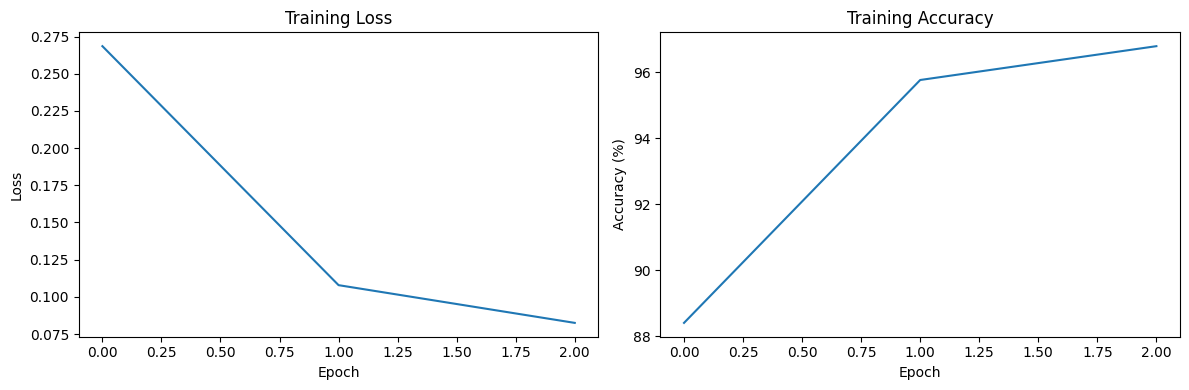

In [5]:
def plot_training_progress(losses, accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

plot_training_progress(losses, accuracies)

TypeError: Invalid shape (5, 1, 6) for image data

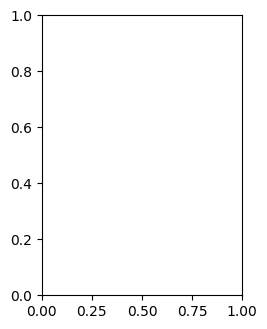

In [7]:
def visualize_messages(sender, dataset, num_samples=10):
        sender.eval()
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        messages = []
        labels = []
        
        with torch.no_grad():
            for i in range(num_samples * len(class_names)):
                image, label = dataset[i]
                message_logits = sender(image.unsqueeze(0).to(device))
                message = F.gumbel_softmax(message_logits, tau=temperature, hard=True).argmax(-1)
                messages.append(message.cpu().numpy())
                labels.append(label)
        
        messages = np.array(messages)
        labels = np.array(labels)
        
        plt.figure(figsize=(15, 8))
        for i, class_name in enumerate(class_names):
            plt.subplot(2, 5, i+1)
            class_messages = messages[labels == i]
            plt.imshow(class_messages.T, cmap='viridis', aspect='auto')
            plt.title(f'{class_name}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Visualize messages
visualize_messages(sender, train_dataset)

def visualize_message_distribution(sender, dataset, num_samples=1000):
    sender.eval()
    messages = []
    labels = []
    
    with torch.no_grad():
        for i in range(num_samples):
            image, label = dataset[i]
            message_logits = sender(image.unsqueeze(0).to(device))
            message = F.gumbel_softmax(message_logits, tau=temperature, hard=True).argmax(-1)
            messages.append(message.cpu().numpy().flatten())
            labels.append(label)
    
    messages = np.array(messages)
    labels = np.array(labels)
    
    tsne = TSNE(n_components=2, random_state=42)
    messages_2d = tsne.fit_transform(messages)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(messages_2d[:, 0], messages_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of messages')
    plt.show()

# Visualize message distribution
visualize_message_distribution(sender, train_dataset)

def visualize_game_instances(sender, receiver, dataset, num_samples=5):
    sender.eval()
    receiver.eval()
    
    for _ in range(num_samples):
        images, candidate_images, target_positions = dataset[random.randint(0, len(dataset)-1)]
        images = images.unsqueeze(0).to(device)
        candidate_images = candidate_images.unsqueeze(0).to(device)
        
        with torch.no_grad():
            messages = sender(images)
            probs = receiver(messages, candidate_images)
            predicted_idx = probs.argmax(1).item()
        
        plt.figure(figsize=(15, 3))
        for i in range(candidate_images.size(1)):
            plt.subplot(1, candidate_images.size(1), i+1)
            img = candidate_images[0, i].cpu().permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # unnormalize
            plt.imshow(img)
            if i == target_positions.item():
                plt.title('Target', color='green')
            elif i == predicted_idx:
                plt.title('Predicted', color='red')
            plt.axis('off')
        plt.suptitle(f"{'Success' if target_positions.item() == predicted_idx else 'Failure'}", fontsize=16)
        plt.show()

# Visualize game instances
visualize_game_instances(sender, receiver, test_dataset)

print("Notebook execution completed. The referential game has been trained, evaluated, and visualized.")